In [ ]:
#Import Library yang dibutuhkan
import yfinance as yf
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)
# Mute general warnings
import warnings
warnings.filterwarnings('ignore')

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from hyperopt import fmin, tpe, hp, Trials, space_eval
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

### Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,GRU,Dropout,Dense
from tensorflow.keras.optimizers import Adamax

In [ ]:
#download datset ticker untuk saham Bank BCA dari yahoo finance
df = yf.download('BBCA.JK', start='2008-05-05', end='2024-05-05')
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-05-05,630.0,640.0,625.0,630.0,469.204712,105005000
2008-05-06,635.0,650.0,625.0,630.0,469.204712,119735000
2008-05-07,630.0,635.0,620.0,635.0,472.928497,42477500
2008-05-08,630.0,645.0,625.0,635.0,472.928497,102915000
2008-05-09,635.0,640.0,625.0,630.0,469.204712,31062500
...,...,...,...,...,...,...
2024-04-26,9700.0,9825.0,9625.0,9625.0,9625.000000,100932900
2024-04-29,9525.0,9850.0,9525.0,9800.0,9800.000000,90063500
2024-04-30,10050.0,10050.0,9800.0,9800.0,9800.000000,109623000


In [ ]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3944 entries, 2008-05-05 to 2024-05-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3944 non-null   float64
 1   High       3944 non-null   float64
 2   Low        3944 non-null   float64
 3   Close      3944 non-null   float64
 4   Adj Close  3944 non-null   float64
 5   Volume     3944 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 215.7 KB


In [ ]:
#mengecek missing value
df.isnull().values.any()

False

In [ ]:
# Asumsi 'df' adalah dfFrame dengan kolom 'Open', 'High', 'Low', 'Close', 'Volume', dan indeks tanggal
fig = make_subplots(rows=2, cols=1,
                    subplot_titles=("Harga Saham (OHLC)", "Volume Perdagangan"))

# Menambahkan trace OHLC
fig.add_trace(go.Ohlc(x=df.index,
                      open=df['Open'],
                      high=df['High'],
                      low=df['Low'],
                      close=df['Close'],
                      name='Harga'), row=1, col=1)

# Menambahkan trace Volume
fig.add_trace(go.Scatter(x=df.index, y=df['Volume'], name='Volume'), row=2, col=1)

# Memperbarui layout untuk menyembunyikan range slider pada sumbu x
fig.update(layout_xaxis_rangeslider_visible=False)

# Memperbarui layout untuk menambahkan judul utama
fig.update_layout(title_text="Analisis Saham dan Volume Perdagangan")

# Menampilkan figure
fig.show()

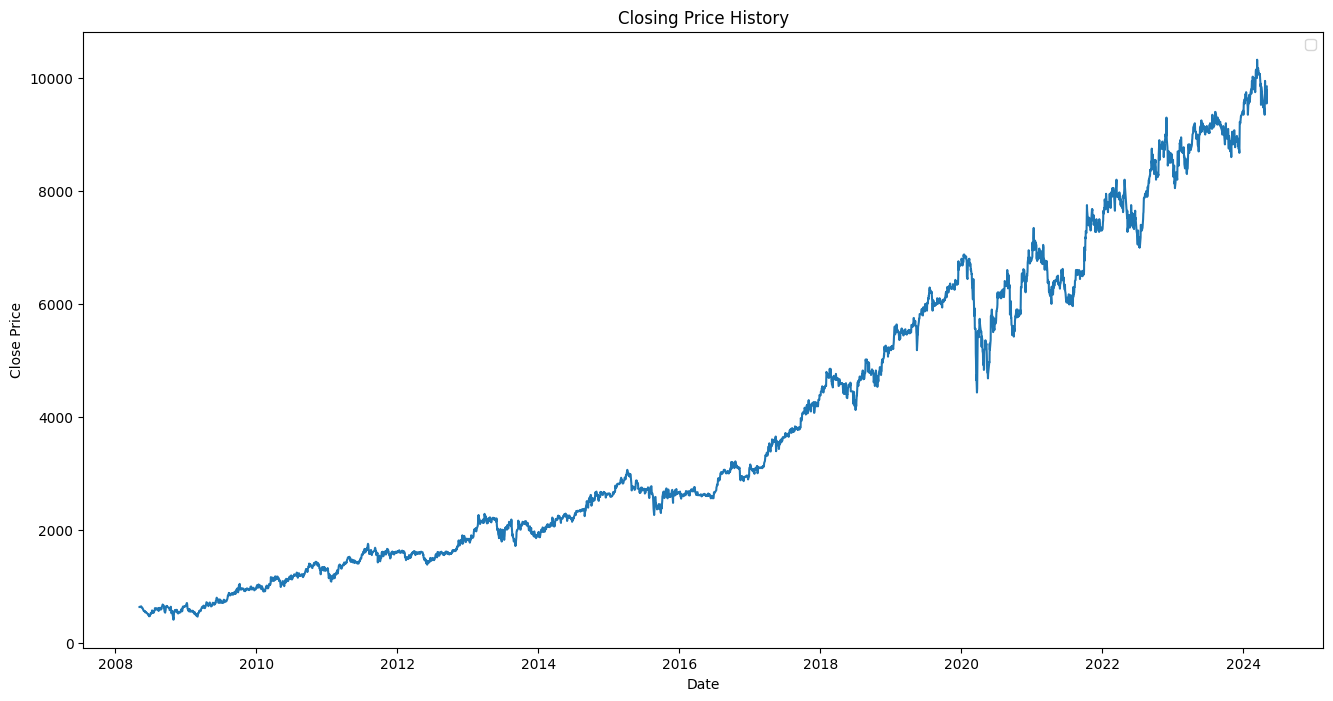

In [ ]:
## Lets take a quick view of the Trend in the Closing Price
plt.figure(figsize=(16,8))
plt.title("Closing Price History")
plt.plot(df['Close'])
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

In [ ]:
# Plot all prices
fig = go.Figure()

fig.add_trace(go.Scatter(x=df.index, y=df['Open'], mode='lines', name='Opening Price', line=dict(color='red')))
fig.add_trace(go.Scatter(x=df.index, y=df['Close'], mode='lines', name='Closing Price', line=dict(color='green')))
fig.add_trace(go.Scatter(x=df.index, y=df['Low'], mode='lines', name='Low Price', line=dict(color='black')))
fig.add_trace(go.Scatter(x=df.index, y=df['High'], mode='lines', name='High Price', line=dict(color='blue')))

fig.update_layout(
    title='Stock Price History',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Stock Price'),
    legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
)

# Plot subplots for each individual price
fig_subplots = make_subplots(rows=2, cols=2, subplot_titles=('Opening Price', 'Closing Price', 'Low Price', 'High Price'))

fig_subplots.add_trace(go.Scatter(x=df.index, y=df['Open'], mode='lines', name='Opening Price', line=dict(color='red')), row=1, col=1)
fig_subplots.add_trace(go.Scatter(x=df.index, y=df['Close'], mode='lines', name='Closing Price', line=dict(color='green')), row=1, col=2)
fig_subplots.add_trace(go.Scatter(x=df.index, y=df['Low'], mode='lines', name='Low Price', line=dict(color='black')), row=2, col=1)
fig_subplots.add_trace(go.Scatter(x=df.index, y=df['High'], mode='lines', name='High Price', line=dict(color='blue')), row=2, col=2)

fig_subplots.update_layout(title='Stock Price Subplots', showlegend=False)

fig.show()
fig_subplots.show()

In [ ]:
#Melihat harga penutupan dan harga terendah
df.iloc[:, 2:-1].describe()

,Low,Close,Adj Close
count,3944.000000,3944.000000,3944.000000
mean,3855.394270,3892.532961,3524.165517
std,2658.719173,2678.600676,2617.614654
min,400.000000,405.000000,309.109100
25%,1580.000000,1600.000000,1311.991455
50%,2820.000000,2857.500000,2437.900513
75%,6021.250000,6081.250000,5571.796143
max,10150.000000,10325.000000,10092.431641


# Normalisasi

In [ ]:
#Memilih Harga Penutupan (Closing Price)
df_scaler = df.copy()
df_scaler[['Close']]

#Normalisasi df menggunakan Min-Max Scaler
df_scaler[['Close']] =  MinMaxScaler(feature_range=(0, 1)).fit_transform(df_scaler[['Close']])

#Mendrop kolom yang tidak digunakan untuk prediksi
df_scaler.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)

df_scaler

,Close
Date,
2008-05-05,0.022681
2008-05-06,0.022681
2008-05-07,0.023185
2008-05-08,0.023185
2008-05-09,0.022681
...,...
2024-04-26,0.929435
2024-04-29,0.947077
2024-04-30,0.947077


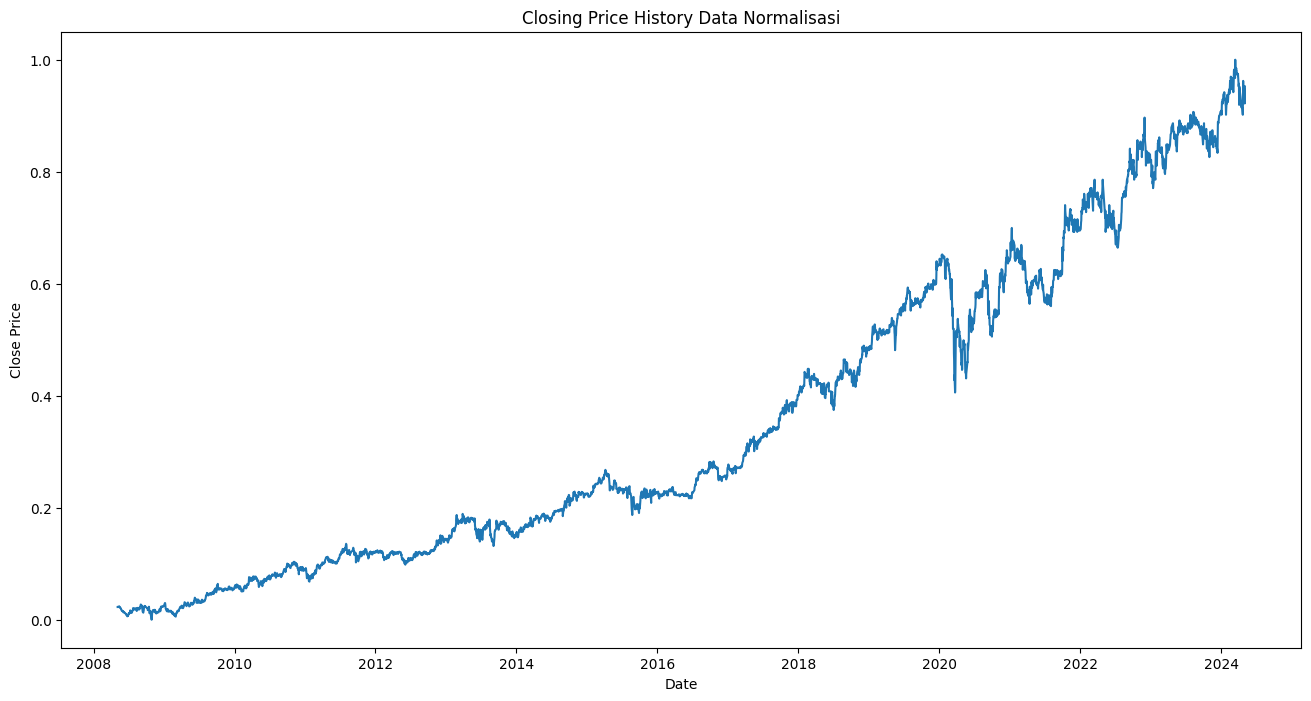

In [ ]:
## Lets take a quick view of the Trend in the Closing Price
plt.figure(figsize=(16,8))
plt.title("Closing Price History Data Normalisasi")
plt.plot(df_scaler)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

In [ ]:
# Data preparation
def create_df(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        lag_values = data[i:(i + time_steps), 0]
        X.append(np.concatenate([lag_values, [data[i + time_steps, 0]]]))
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# SPLIT DATA

In [ ]:
df_scaler = df_scaler.values

In [ ]:
time_steps = 120
X, y = create_df(df_scaler, time_steps)

In [ ]:
# Splitting into train, test, and validation sets
train_size = int(len(X) * 0.8)
test_size = int(len(X) * 0.1)
validation_size = len(X) - train_size - test_size

X_train, X_test, X_val = X[:train_size], X[train_size:train_size + test_size], X[train_size + test_size:]
y_train, y_test, y_val = y[:train_size], y[train_size:train_size + test_size], y[train_size + test_size:]

In [ ]:
# Print shapes of the datasets
print("Shapes of the datasets:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")

Shapes of the datasets:
X_train: (3059, 121), y_train: (3059,)
X_test: (382, 121), y_test: (382,)
X_val: (383, 121), y_val: (383,)


# Data Train

In [ ]:
data_train =  pd.DataFrame(df_scaler[:train_size])

print(f"Data Train")
data_train

Data Train


,0
0,0.022681
1,0.022681
2,0.023185
3,0.023185
4,0.022681
...,...
3054,0.591734
3055,0.616431
3056,0.607863
3057,0.614415


# Data Test

In [ ]:
data_test = pd.DataFrame(df_scaler[train_size:train_size + test_size])

print(f"Data Test")
data_test

Data Test


,0
0,0.592742
1,0.597782
2,0.588710
3,0.544859
4,0.554435
...,...
377,0.758065
378,0.755544
379,0.758065
380,0.760585


# Data Validation

In [ ]:
data_validation = pd.DataFrame(df_scaler[train_size + test_size:train_size + test_size + validation_size])

print(f"Data Validation")
data_validation

Data Validation


,0
0,0.750504
1,0.753024
2,0.763105
3,0.758065
4,0.755544
...,...
378,0.863911
379,0.851310
380,0.843750
381,0.853831


#Hyperparameter

In [ ]:
# Reshape data for LSTM and GRU models
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_val_lstm = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

X_train_gru = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_gru = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
X_val_gru = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

In [ ]:
#Define hyperparameter search space
space = {
    'units': hp.choice('units', [50, 100, 150]),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning rate', np.log(0.001), np.log(0.01)),
    'epochs': hp.choice('epochs', [50, 100, 150, 200]),
    'batch_size': hp.choice('batch_size', [32, 64, 128])
}

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Create a function to build and train the model with hyperparameters
from tensorflow.keras.optimizers import Adamax

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create a function to build and train the model with hyperparameters
def objective(params, model_type, X_train, y_train, X_val, y_val):
    model = Sequential()
    if model_type == 'lstm':
        model.add(LSTM(units=params['units'], return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(params['dropout_rate']))
        model.add(LSTM(units=params['units'], return_sequences=True, activation='tanh'))
        model.add(Dropout(params['dropout_rate']))
        model.add(LSTM(units=params['units'], activation='tanh'))
        model.add(Dense(units=1))

    elif model_type == 'gru':
        model.add(GRU(units=params['units'], return_sequences=True, activation='tanh', input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(params['dropout_rate']))
        model.add(GRU(units=params['units'], return_sequences=True, activation='tanh'))
        model.add(Dropout(params['dropout_rate']))
        model.add(GRU(units=params['units'], activation='tanh'))
        model.add(Dense(units=1))

    model.compile(optimizer=Adamax(learning_rate=params['learning_rate']), loss='mean_squared_error')

    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'],
                        validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)

    y_pred = model.predict(X_val)
    y_pred = scaler.inverse_transform(y_pred)
    y_val_orig = scaler.inverse_transform(y_val.reshape(-1, 1))

    mse = mean_squared_error(y_val_orig, y_pred)
    return {'loss': mse, 'status': 'ok', 'params': params}

# Set up the Trials object to keep track of the optimization process
trials_lstm = Trials()
trials_gru = Trials()

# Set up the Trials object to keep track of the optimization process
trials_lstm = Trials()
trials_gru = Trials()

# Use the fmin function for Bayesian optimization for LSTM and GRU
best_lstm = fmin(fn=lambda params: objective(params, 'lstm', X_train_lstm, y_train, X_val_lstm, y_val),
                 space=space, algo=tpe.suggest, max_evals=20, trials=trials_lstm)

best_gru = fmin(fn=lambda params: objective(params, 'gru', X_train_gru, y_train, X_val_gru, y_val),
                space=space, algo=tpe.suggest, max_evals=20, trials=trials_gru)

12/12 [==============================] - 2s 92ms/step

12/12 [==============================] - 4s 217ms/step

12/12 [==============================] - 2s 96ms/step

12/12 [==============================] - 2s 60ms/step

12/12 [==============================] - 2s 58ms/step

12/12 [==============================] - 2s 56ms/step

12/12 [==============================] - 2s 96ms/step

12/12 [==============================] - 3s 89ms/step

12/12 [==============================] - 2s 66ms/step

12/12 [==============================] - 3s 79ms/step

12/12 [==============================] - 5s 291ms/step

12/12 [==============================] - 3s 149ms/step

12/12 [==============================] - 4s 236ms/step

12/12 [==============================] - 2s 60ms/step

12/12 [==============================] - 2s 61ms/step

12/12 [==============================] - 4s 234ms/step

12/12 [==============================] - 3s 127ms/step

12/12 [==============================] - 2s 100ms/step

12/

In [ ]:
import math
from hyperopt import hp, fmin, tpe, Trials, space_eval
import tensorflow as tf

In [ ]:
# Extract results for LSTM
results_lstm = []
for trial in trials_lstm.trials:
    mse = trial['result']['loss']
    params = trial['result']['params']
    rmse = math.sqrt(mse)
    results_lstm.append({**params, 'mse': mse, 'rmse': rmse})

# Convert results to DataFrame
df_lstm = pd.DataFrame(results_lstm)

# Display the DataFrames
print("LSTM Hyperparameter Results:")
print(df_lstm)

# Get the best hyperparameters from the optimization results
best_params_lstm = space_eval(space, best_lstm)
# Display the best hyperparameters
print("\nBest Hyperparameters for LSTM:")
print(best_params_lstm)

LSTM Hyperparameter Results:
    batch_size  dropout_rate  epochs  learning_rate  units            mse  \
0           32      0.214735     200       0.005358    100   15459.465947   
1          128      0.288575      50       0.001957    150   38473.957165   
2           32      0.296294      50       0.006770    100   39594.406658   
3           32      0.341257     200       0.001473     50   60788.411131   
4          128      0.231268     100       0.001125     50   72764.899702   
5           64      0.433009     150       0.008730     50  225065.080393   
6          128      0.409086     100       0.001930    100   48825.319537   
7           32      0.223987     150       0.002125     50   87808.661657   
8           32      0.312214     200       0.002589     50  162983.833254   
9          128      0.453864     150       0.005560     50  251664.938085   
10          32      0.462604     150       0.002289    150   23095.963263   
11         128      0.465900     150       0.00

In [ ]:
# Extract results for GRU
results_gru = []
for trial in trials_gru.trials:
    mse = trial['result']['loss']
    params = trial['result']['params']
    rmse = math.sqrt(mse)
    results_gru.append({**params, 'mse': mse, 'rmse': rmse})


# Convert results to DataFrame
df_gru = pd.DataFrame(results_gru)

# Display the DataFrames
print("\nGRU Hyperparameter Results:")
print(df_gru)

# Get the best hyperparameters from the optimization results
best_params_gru = space_eval(space, best_gru)

# Display the best hyperparameters
print("\nBest Hyperparameters for GRU:")
print(best_params_gru)


GRU Hyperparameter Results:
    batch_size  dropout_rate  epochs  learning_rate  units           mse  \
0           32      0.212267     200       0.001816    100  17178.053092   
1          128      0.393145     100       0.001443    100  20675.926347   
2          128      0.295785      50       0.004818    150  15218.580570   
3           32      0.329574     150       0.001167    150  17154.091083   
4           64      0.485682     150       0.003592    150  16594.912143   
5           64      0.453617      50       0.002515    100  21071.790303   
6           32      0.374194      50       0.008707    150  27015.259349   
7           32      0.260658      50       0.007238     50  17353.086923   
8           64      0.471652     100       0.009426    150  23068.125244   
9           64      0.366189     150       0.007113    100  14116.520040   
10          32      0.363097      50       0.009051     50  42728.779803   
11          64      0.457262     150       0.001334    100 

In [ ]:
# Build the final LSTM model using the best hyperparameters
final_model_lstm = Sequential([
    LSTM(units=best_params_lstm['units'], return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    Dropout(best_params_lstm['dropout_rate']),
    LSTM(units=best_params_lstm['units'], return_sequences=True),
    Dropout(best_params_lstm['dropout_rate']),
    LSTM(units=best_params_lstm['units']),
    Dense(units=1)
])

final_model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params_lstm['learning_rate']),
                         loss='mean_squared_error')

# Train the final LSTM model
history_lstm = final_model_lstm.fit(X_train_lstm, y_train, epochs=best_params_lstm['epochs'],
                                    batch_size=best_params_lstm['batch_size'], verbose=2,
                                    validation_data=(X_val_lstm, y_val), callbacks=[early_stopping])

Epoch 1/200
96/96 - 39s - loss: 0.0049 - val_loss: 0.0022 - 39s/epoch - 405ms/step
Epoch 2/200
96/96 - 31s - loss: 3.7909e-04 - val_loss: 6.4106e-04 - 31s/epoch - 326ms/step
Epoch 3/200
96/96 - 29s - loss: 3.5897e-04 - val_loss: 3.5768e-04 - 29s/epoch - 306ms/step
Epoch 4/200
96/96 - 30s - loss: 2.2306e-04 - val_loss: 5.2627e-04 - 30s/epoch - 310ms/step
Epoch 5/200
96/96 - 30s - loss: 2.0751e-04 - val_loss: 0.0073 - 30s/epoch - 308ms/step
Epoch 6/200
96/96 - 29s - loss: 2.2552e-04 - val_loss: 0.0019 - 29s/epoch - 306ms/step
Epoch 7/200
96/96 - 31s - loss: 2.1001e-04 - val_loss: 0.0023 - 31s/epoch - 325ms/step
Epoch 8/200
96/96 - 30s - loss: 2.0002e-04 - val_loss: 2.4176e-04 - 30s/epoch - 307ms/step
Epoch 9/200
96/96 - 32s - loss: 1.5433e-04 - val_loss: 2.4958e-04 - 32s/epoch - 330ms/step
Epoch 10/200
96/96 - 30s - loss: 1.3708e-04 - val_loss: 0.0011 - 30s/epoch - 312ms/step
Epoch 11/200
96/96 - 30s - loss: 1.8409e-04 - val_loss: 0.0073 - 30s/epoch - 308ms/step
Epoch 12/200
96/96 - 30s 

In [ ]:
# Build the final GRU model using the best hyperparameters
final_model_gru = Sequential([
    GRU(units=best_params_gru['units'], return_sequences=True, input_shape=(X_train_gru.shape[1], 1)),
    Dropout(best_params_gru['dropout_rate']),
    GRU(units=best_params_gru['units'], return_sequences=True),
    Dropout(best_params_gru['dropout_rate']),
    GRU(units=best_params_gru['units']),
    Dense(units=1)
])

final_model_gru.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_params_gru['learning_rate']),
                        loss='mean_squared_error')

# Train the final GRU model
history_gru = final_model_gru.fit(X_train_gru, y_train, epochs=best_params_gru['epochs'],
                                  batch_size=best_params_gru['batch_size'], verbose=2,
                                  validation_data=(X_val_gru, y_val), callbacks=[early_stopping])

Epoch 1/150
48/48 - 46s - loss: 0.0190 - val_loss: 0.0054 - 46s/epoch - 951ms/step
Epoch 2/150
48/48 - 34s - loss: 5.2338e-04 - val_loss: 2.8757e-04 - 34s/epoch - 711ms/step
Epoch 3/150
48/48 - 33s - loss: 2.8777e-04 - val_loss: 7.3965e-04 - 33s/epoch - 691ms/step
Epoch 4/150
48/48 - 37s - loss: 2.4533e-04 - val_loss: 3.2481e-04 - 37s/epoch - 774ms/step
Epoch 5/150
48/48 - 33s - loss: 2.1495e-04 - val_loss: 5.6049e-04 - 33s/epoch - 688ms/step
Epoch 6/150
48/48 - 35s - loss: 1.9225e-04 - val_loss: 5.0128e-04 - 35s/epoch - 719ms/step
Epoch 7/150
48/48 - 34s - loss: 2.0373e-04 - val_loss: 0.0013 - 34s/epoch - 700ms/step
Epoch 8/150
48/48 - 34s - loss: 1.9824e-04 - val_loss: 0.0022 - 34s/epoch - 706ms/step
Epoch 9/150
48/48 - 37s - loss: 2.0026e-04 - val_loss: 5.1845e-04 - 37s/epoch - 778ms/step
Epoch 10/150
48/48 - 35s - loss: 1.8666e-04 - val_loss: 0.0014 - 35s/epoch - 729ms/step
Epoch 11/150
48/48 - 33s - loss: 1.8770e-04 - val_loss: 5.5722e-04 - 33s/epoch - 687ms/step
Epoch 12/150
48/4

In [ ]:
import numpy as np
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Model evaluation for LSTM
y_pred_lstm = final_model_lstm.predict(X_test_lstm)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)
y_test_orig_lstm = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics for LSTM
mse_lstm = mean_squared_error(y_test_orig_lstm, y_pred_lstm)
rmse_lstm = math.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_test_orig_lstm, y_pred_lstm)
mape_lstm = np.mean(np.abs((y_test_orig_lstm - y_pred_lstm) / y_test_orig_lstm)) * 100

# Display results for LSTM
print("Performance Metrics for LSTM:")
print("Mean Squared Error (MSE):", mse_lstm)
print("Root Mean Squared Error (RMSE):", rmse_lstm)
print("Mean Absolute Error (MAE):", mae_lstm)
print("Mean Absolute Percentage Error (MAPE):", mape_lstm)

# Model evaluation for GRU
y_pred_gru = final_model_gru.predict(X_test_gru)
y_pred_gru = scaler.inverse_transform(y_pred_gru)
y_test_orig_gru = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics for GRU
mse_gru = mean_squared_error(y_test_orig_gru, y_pred_gru)
rmse_gru = math.sqrt(mse_gru)
mae_gru = mean_absolute_error(y_test_orig_gru, y_pred_gru)
mape_gru = np.mean(np.abs((y_test_orig_gru - y_pred_gru) / y_test_orig_gru)) * 100

# Display results for GRU
print("Performance Metrics for GRU:")
print("Mean Squared Error (MSE):", mse_gru)
print("Root Mean Squared Error (RMSE):", rmse_gru)
print("Mean Absolute Error (MAE):", mae_gru)
print("Mean Absolute Percentage Error (MAPE):", mape_gru)

12/12 [==============================] - 3s 107ms/step
Performance Metrics for LSTM:
Mean Squared Error (MSE): 43241.65269599348
Root Mean Squared Error (RMSE): 207.94627358044548
Mean Absolute Error (MAE): 182.54829766238547
Mean Absolute Percentage Error (MAPE): 2.633677249297793
12/12 [==============================] - 2s 106ms/step
Performance Metrics for GRU:
Mean Squared Error (MSE): 11308.37141058333
Root Mean Squared Error (RMSE): 106.34082664049274
Mean Absolute Error (MAE): 86.64868291884815
Mean Absolute Percentage Error (MAPE): 1.2243834053792706


In [ ]:
# Visualize predictions for the final LSTM model
fig = go.Figure()

fig.add_trace(go.Scatter(x=df.index[train_size + time_steps:train_size + time_steps + test_size],
                         y=y_test_orig_lstm.flatten(),
                         mode='lines',
                         name="Actual Stock Prices",
                         line=dict(color='blue')))

fig.add_trace(go.Scatter(x=df.index[train_size + time_steps:train_size + time_steps + test_size],
                         y=y_pred_lstm.flatten(),
                         mode='lines',
                         name="Predicted Stock Prices (LSTM)",
                         line=dict(color='red')))

# Visualize predictions for the final GRU model
fig.add_trace(go.Scatter(x=df.index[train_size + time_steps:train_size + time_steps + test_size],
                         y=y_pred_gru.flatten(),
                         mode='lines',
                         name="Predicted Stock Prices (GRU)",
                         line=dict(color='orange')))

fig.update_layout(title="Stock Price Prediction (LSTM vs GRU)",
                  xaxis_title="Date",
                  yaxis_title="Stock Price (IDR)",
                  template='plotly_dark',
                  legend=dict(orientation="h", yanchor="bottom",y=1.02, xanchor="right",x=1))

fig.show()

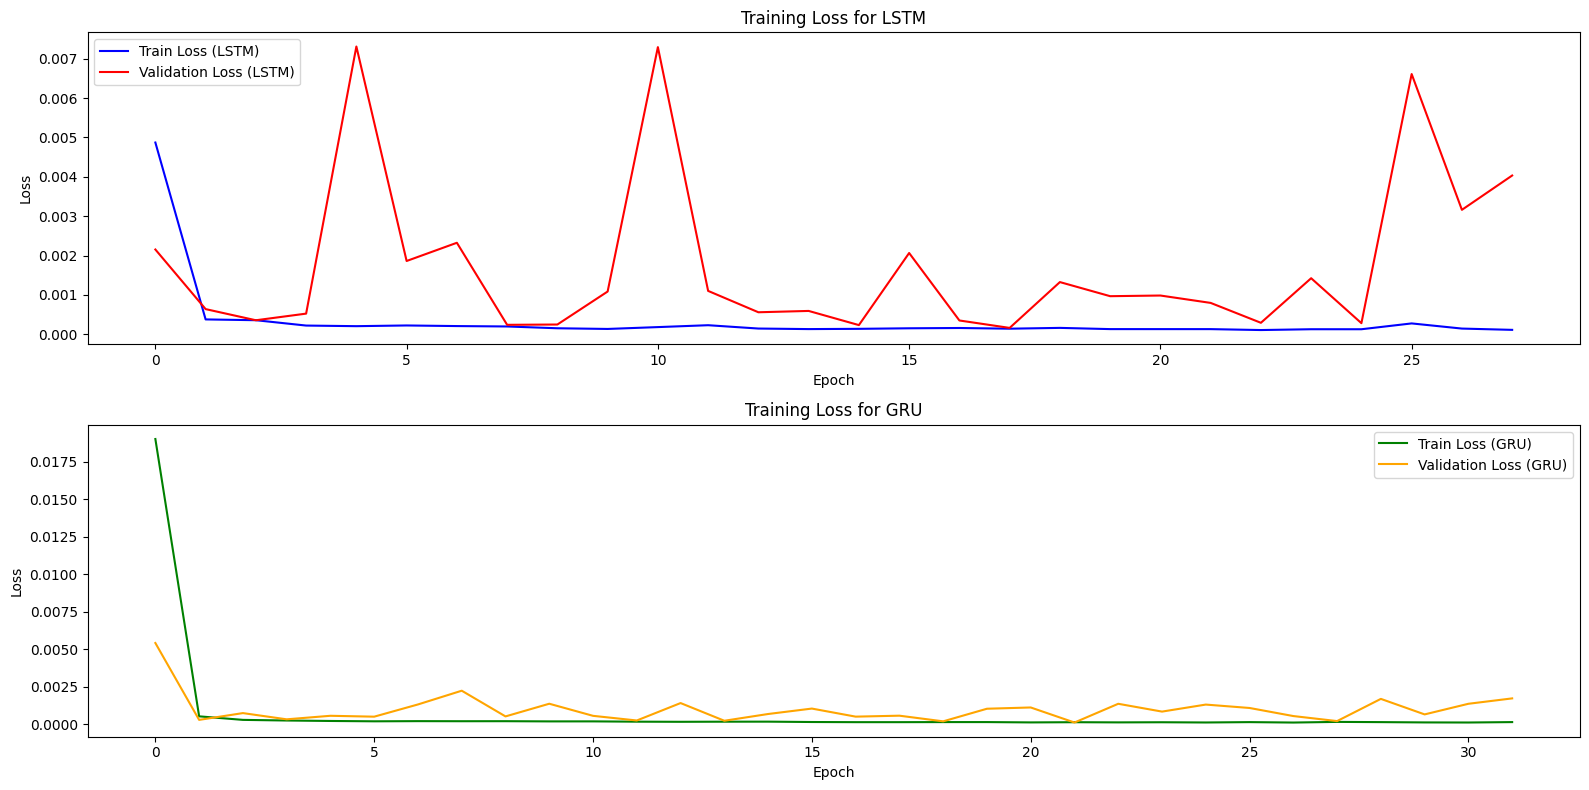

In [ ]:
# Plot training history using Matplotlib
plt.figure(figsize=(16, 8))

# Plot training loss for LSTM
plt.subplot(2, 1, 1)
plt.plot(history_lstm.history['loss'], label='Train Loss (LSTM)', color='blue')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss (LSTM)', color='red')
plt.title('Training Loss for LSTM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training loss for GRU
plt.subplot(2, 1, 2)
plt.plot(history_gru.history['loss'], label='Train Loss (GRU)', color='green')
plt.plot(history_gru.history['val_loss'], label='Validation Loss (GRU)', color='orange')
plt.title('Training Loss for GRU')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()

In [ ]:
actual_values = pd.DataFrame(scaler.inverse_transform(y_test.reshape(-1, 1)), columns=['Actual'])
lstm_predictions = pd.DataFrame(y_pred_lstm, columns=['LSTM Prediction'])
gru_predictions = pd.DataFrame(y_pred_gru, columns=['GRU Prediction'])

# Combining into a single DataFrame
results_df = pd.concat([actual_values, lstm_predictions, gru_predictions], axis=1)
results_df

,Actual,LSTM Prediction,GRU Prediction
0,6800.0,7112.196777,6902.562500
1,6720.0,7057.937500,6881.726074
2,6605.0,6984.404297,6829.368164
3,6705.0,6928.654297,6804.020020
4,6765.0,6909.784180,6822.312012
...,...,...,...
377,8475.0,8621.057617,8526.926758
378,8475.0,8591.591797,8505.323242
379,8375.0,8549.937500,8478.105469
380,8425.0,8517.592773,8464.850586


In [ ]:
# Function to make future predictions using GRU model
def predict_future(model, data, n_steps, n_days):
    predictions = []
    current_input = data[-n_steps:].reshape((1, n_steps, 1))

    for _ in range(n_days):
        next_prediction = model.predict(current_input)
        predictions.append(next_prediction[0, 0])
        current_input = np.append(current_input[:, 1:, :], next_prediction.reshape((1, 1, 1)), axis=1)

    return np.array(predictions)

# Assuming the final GRU model and scaler are already defined and trained
n_days = 30  # Number of days to predict
future_predictions = predict_future(final_model_gru, df_scaler, time_steps , n_days)

# Inverse transform the predictions to get actual stock prices
future_predictions_actual = scaler.inverse_transform(future_predictions.reshape(-1, 1))

# Creating a DataFrame for the future predictions with numbering
future_predictions_df = pd.DataFrame({'GRU Prediction': future_predictions_actual.flatten()},
                                     index=np.arange(1, len(future_predictions_actual) + 1))

# Display the table
future_predictions_df

1/1 [==============================] - 0s 39ms/step


,GRU Prediction
1,9677.320312
2,9695.114258
3,9677.531250
4,9657.858398
5,9654.891602
6,9645.131836
7,9630.516602
8,9622.441406
9,9613.541016
10,9601.708984


In [ ]:
# Generate index for the future dates (numbering)
future_dates = np.arange(len(df_scaler), len(df_scaler) + n_days)

# Extract dates for actual data
actual_dates = pd.date_range(start='2008-05-05', periods=len(df_scaler), freq='B')
# Plot using Plotly
fig = go.Figure()

# Add actual stock prices trace
fig.add_trace(go.Scatter(x=actual_dates,
                         y=scaler.inverse_transform(df_scaler.flatten().reshape(-1, 1)).flatten(),
                         mode='lines',
                         name='Actual Stock Prices',
                         line=dict(color='blue')))

# Add future predictions trace
fig.add_trace(go.Scatter(x=pd.date_range(start=actual_dates[-1], periods=n_days + 1, freq='B')[1:],
                         y=future_predictions_actual.flatten(),
                         mode='lines',
                         name='Future Predictions (GRU)',
                         line=dict(color='orange', dash='dot')))

fig.update_layout(title='Stock Price Prediction for Next Month (GRU)',
                  xaxis_title='Date',
                  yaxis_title='Stock Price (IDR)',
                  template='plotly_dark',
                  legend=dict(x=0.5, y=1, xanchor='left', yanchor='bottom', orientation='h'))

fig.show()